In [226]:
import pandas as pd
import numpy as np

boxrec_data = pd.read_csv('boxrec_tables.csv')
df = pd.DataFrame(boxrec_data)

stance - missing = 82/793 - pct missing = 10.34%    
height - missing = 98/793 - pct missing = 12.36%    
reach - missing = 380/793 - pct missing = 47.92%    
birth place - missing = 79/793 - pct missing = 9.96%

age - missing = 19/793 - pct missing = 2.4%

In [227]:
df.replace(to_replace='None', value=np.nan, regex=True, inplace=True)

df.insert(3, 'div index', '')

div_list = ['heavy', 'cruiser', 'lightheavy', 'supermiddle', 'middle', 'superwelter', 'welter', 'superlight', 'light', 'feather', 'superbantam', 'bantam', 'superfly', 'fly', 'lightfly', 'minimum']

x = 0
for value in df['division']:
    df.at[x, 'div index'] = div_list.index(value)
    x += 1

In [228]:
ds = df.sort_values(by=['div index', 'division rating'], ascending=True)
# ds.dtypes 
# Can see age/height/reach need to be turned to float64s
cols_to_convert = ['age', 'height', 'reach']

for col in cols_to_convert:
    ds[col] = ds[col].astype(float)

In [229]:
dropped_missing_height_ds = ds.dropna(subset=['height'])

#dropped_missing_height_ds
#Dropping missing height values gives 695 rows 
dropped_age_ds = dropped_missing_height_ds.dropna(subset=['age'])
#dropped_age_ds
#Dropping the missing age values from the new dataframe leaves 688 rows of data.
new_ds = dropped_age_ds


In [230]:
average_by_division = new_ds.groupby(['div index']).mean(numeric_only=True).round(2)
average_everything_numeric = new_ds.mean(numeric_only=True).round(2)

#average_by_division

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8), dpi=120)

for x in average_by_division:
    plt.plot(average_by_division[x], label=x)

plt.title('Average of column values by Division')
plt.xlabel('div index - 0=heavyweight, 15=minimumweight')
plt.ylabel('Average value')
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()

width = 18
height = 8
fig.set_size_inches(width, height)
ax.plot(average_by_division['height'], label='height')
ax.plot(average_by_division['KOs'], label='KOs')
ax.plot(average_by_division['rounds'], label='rounds')
ax.plot(average_by_division['reach'], label='reach')

ax2 = ax.twinx()
ax2.plot(average_by_division['age'], label='age', color='black')
ax2.set_ylabel('Age')
ax.legend()
ax.set_xticks(np.arange(0, 16, 1))
ax.set_title('Average of column values by Division')
ax.set_xlabel('div index - 0=heavyweight, 15=minimumweight')
ax.set_ylabel('Average value')

In [231]:
def replace_nan_with_mean(dataframe, column, grouping_column):
    dataframe[column] = dataframe.groupby(grouping_column)[column].transform(lambda x: x.fillna(round(x.mean(), 2)))

In [ ]:
diff_reach = new_ds.reach - new_ds.height
new_ds.insert(12, 'diff reach', diff_reach)

replace_nan_with_mean(new_ds, 'diff reach', 'division')

In [239]:
new_ds.reach.isnull().sum()

0

In [ ]:
new_list = new_ds.reach.isnull().index
reach_min = new_ds.reach.min()

for x in new_list:
    if new_ds.reach[x] >= reach_min:
        pass
    else:
        new_ds.reach[x] = new_ds.height[x] + new_ds['diff reach'][x]

In [ ]:
new_ds.reach = new_ds.height + new_ds['diff reach']

new_ds.reach.head(20)

<AxesSubplot: xlabel='height', ylabel='reach'>

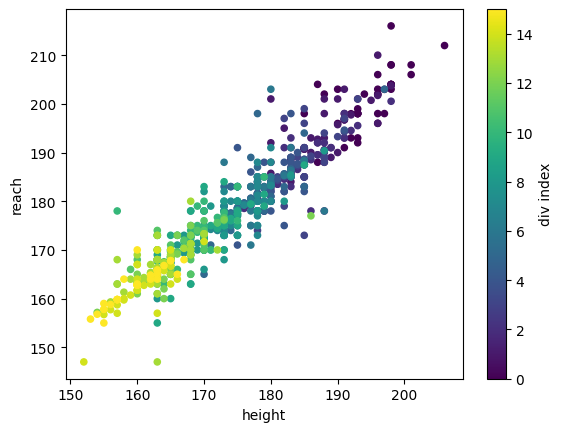

In [240]:
new_ds.plot.scatter(x='height', y='reach', c='div index', colormap='viridis')

clear relationship between the division and the height/reach of a boxer - the heavier the division, the greater the fighter's length or reach. there are some obvious outliers in the data too.

In [241]:
average_by_division = new_ds.groupby(['div index']).mean(numeric_only=True).round(2)
average_everything_numeric = new_ds.mean(numeric_only=True).round(2)

average_by_division

,division rating,bouts,rounds,KOs,age,height,reach,diff reach,wins,losses,draws,KO wins,KO losses
div index,,,,,,,,,,,,,
0,26.36,23.47,111.19,69.30,33.21,193.04,199.01,5.97,21.28,1.77,0.28,15.81,0.85
1,24.00,24.64,129.90,62.04,32.79,187.05,192.78,5.73,21.98,2.31,0.29,14.88,0.88
2,24.47,21.51,110.98,58.31,31.42,184.86,187.39,2.53,19.47,1.77,0.26,12.44,0.93
3,25.29,24.54,136.42,58.51,30.40,182.38,185.64,3.26,21.69,2.27,0.52,13.90,0.73
4,24.60,24.35,130.56,58.92,30.81,181.05,184.65,3.60,21.95,1.79,0.56,14.21,0.72
5,25.92,25.96,150.67,55.39,30.52,177.81,181.42,3.61,23.06,2.27,0.56,13.94,0.71
6,25.12,22.29,122.04,55.35,30.69,177.23,180.50,3.27,20.25,1.54,0.40,12.25,0.52
7,24.76,23.35,123.43,59.41,29.52,175.43,178.66,3.22,21.50,1.50,0.28,13.61,0.33
8,24.41,26.17,155.20,55.07,29.80,172.30,174.67,2.37,23.70,1.91,0.43,13.91,0.70


Text(0, 0.5, 'Average value')

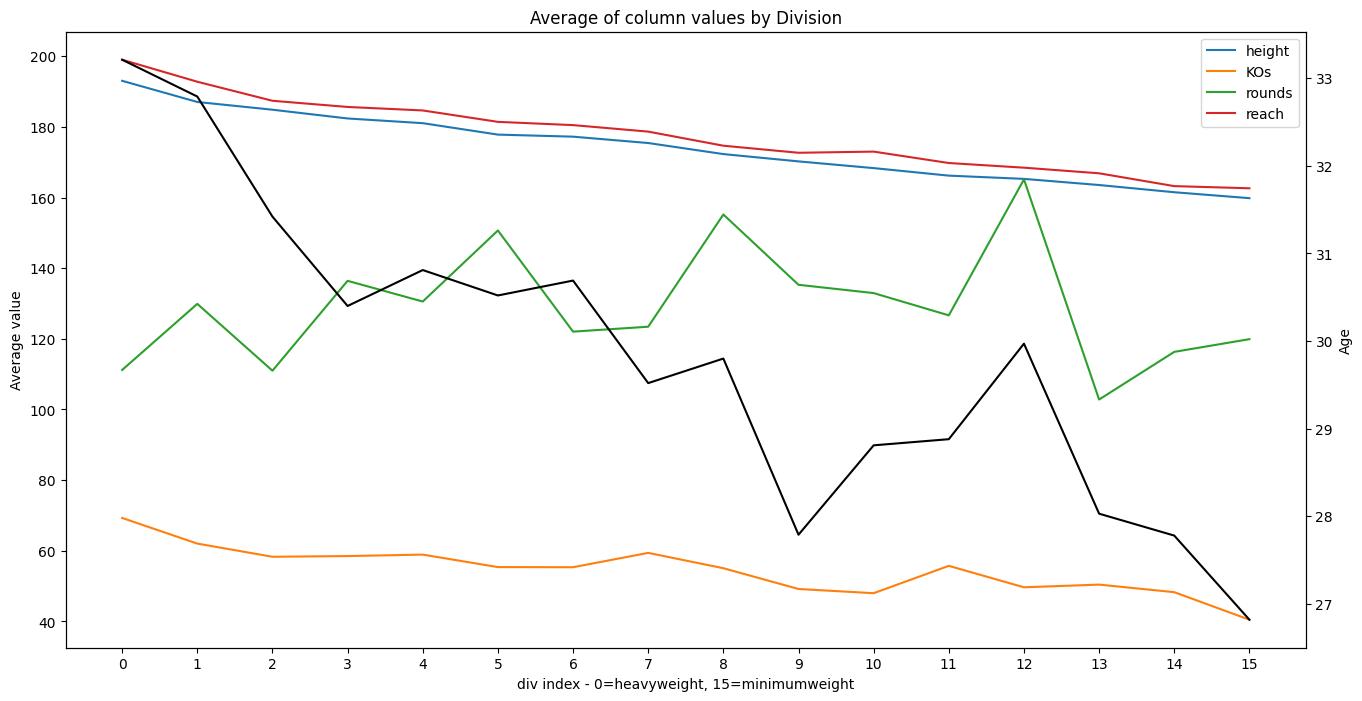

In [285]:
fig, ax = plt.subplots()

width = 16
height = 8
fig.set_size_inches(width, height)
ax.plot(average_by_division['height'], label='height')
ax.plot(average_by_division['KOs'], label='KOs')
ax.plot(average_by_division['rounds'], label='rounds')
ax.plot(average_by_division['reach'], label='reach')

ax2 = ax.twinx()
ax2.plot(average_by_division['age'], label='age', color='black')
ax2.set_ylabel('Age')
ax.legend()
ax.set_xticks(np.arange(0, 16, 1))
ax.set_title('Average of column values by Division')
ax.set_xlabel('div index - 0=heavyweight, 15=minimumweight')
ax.set_ylabel('Average value')

In [ ]:
new_ds['reach'].hist(bins=20, alpha=0.5, legend=True)
new_ds['height'].hist(bins=20, alpha=0.5, legend=True)

<AxesSubplot: >

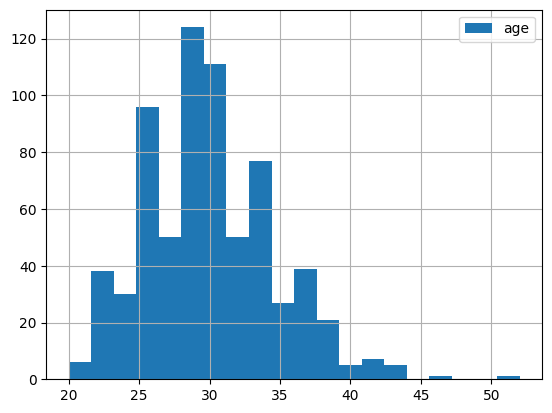

In [283]:
new_ds['age'].hist(bins=20, legend=True)